##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic text classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multiclass classifier to predict the tag for a programming question on Stack Overflow.


In [3]:
!pip install -q tf-nightly

In [4]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [5]:
print(tf.__version__)

2.4.0-dev20200720


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [6]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

    8192/84125825 [..............................] - ETA: 3:10

   73728/84125825 [..............................] - ETA: 1:26

  155648/84125825 [..............................] - ETA: 1:11

  286720/84125825 [..............................] - ETA: 55s 

  516096/84125825 [..............................] - ETA: 39s

  860160/84125825 [..............................] - ETA: 29s

 1433600/84125825 [..............................] - ETA: 20s

 2351104/84125825 [..............................] - ETA: 14s

 3956736/84125825 [>.............................] - ETA: 9s 

 6807552/84125825 [=>............................] - ETA: 6s

10330112/84125825 [==>...........................] - ETA: 4s

15204352/84125825 [====>.........................] - ETA: 2s

20635648/84125825 [======>.......................] - ETA: 2s

26173440/84125825 [========>.....................] - ETA: 1s

31842304/84125825 [==========>...................] - ETA: 1s

37380096/84125825 [============>.................] - ETA: 1s

42950656/84125825 [==============>...............] - ETA: 0s

48537600/84125825 [================>.............] - ETA: 0s

54140928/84125825 [==================>...........] - ETA: 0s

59711488/84125825 [====================>.........] - ETA: 0s

65445888/84125825 [======================>.......] - ETA: 0s

71098368/84125825 [========================>.....] - ETA: 0s

76505088/84125825 [==========================>...] - ETA: 0s

82026496/84125825 [============================>.] - ETA: 0s

84131840/84125825 [==============================] - 1s 0us/step


In [7]:
os.listdir(dataset_dir)

['README', 'imdb.vocab', 'imdbEr.txt', 'train', 'test']

In [8]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_neg.txt',
 'labeledBow.feat',
 'urls_unsup.txt',
 'neg',
 'unsupBow.feat',
 'pos',
 'urls_pos.txt',
 'unsup']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [9]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [10]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [11]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [12]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section. 

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [13]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [14]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [15]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


Note: The Preprocessing APIs used in the following section are experimental in TensorFlow 2.3 and subject to change.

### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `preprocessing.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowecase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: to prevent [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also know as train/serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [16]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. you will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [17]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: it's important to only use your training data when calling adapt (using the test set would leak information).

In [18]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [19]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [20]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [21]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [22]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create our neural network:

In [24]:
embedding_dim = 16

In [25]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, see the [word embedding tutorial](../text/word_embeddings.ipynb).
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [26]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [27]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


  1/625 [..............................] - ETA: 0s - loss: 0.6911 - binary_accuracy: 0.5625

 15/625 [..............................] - ETA: 2s - loss: 0.6933 - binary_accuracy: 0.5333

 30/625 [>.............................] - ETA: 2s - loss: 0.6931 - binary_accuracy: 0.5146

 45/625 [=>............................] - ETA: 1s - loss: 0.6927 - binary_accuracy: 0.5118

 60/625 [=>............................] - ETA: 1s - loss: 0.6920 - binary_accuracy: 0.5292

 75/625 [==>...........................] - ETA: 1s - loss: 0.6915 - binary_accuracy: 0.5296

 90/625 [===>..........................] - ETA: 1s - loss: 0.6912 - binary_accuracy: 0.5264

106/625 [====>.........................] - ETA: 1s - loss: 0.6911 - binary_accuracy: 0.5203

121/625 [====>.........................] - ETA: 1s - loss: 0.6909 - binary_accuracy: 0.5307

136/625 [=====>........................] - ETA: 1s - loss: 0.6905 - binary_accuracy: 0.5478

151/625 [======>.......................] - ETA: 1s - loss: 0.6901 - binary_accuracy: 0.5656

166/625 [======>.......................] - ETA: 1s - loss: 0.6896 - binary_accuracy: 0.5772

182/625 [=======>......................] - ETA: 1s - loss: 0.6891 - binary_accuracy: 0.5872

197/625 [========>.....................] - ETA: 1s - loss: 0.6885 - binary_accuracy: 0.5923

213/625 [=========>....................] - ETA: 1s - loss: 0.6881 - binary_accuracy: 0.5976

229/625 [=========>....................] - ETA: 1s - loss: 0.6875 - binary_accuracy: 0.6051

244/625 [==========>...................] - ETA: 1s - loss: 0.6869 - binary_accuracy: 0.6130

259/625 [===========>..................] - ETA: 1s - loss: 0.6863 - binary_accuracy: 0.6187

274/625 [============>.................] - ETA: 1s - loss: 0.6855 - binary_accuracy: 0.6233

289/625 [============>.................] - ETA: 1s - loss: 0.6850 - binary_accuracy: 0.6276

305/625 [=============>................] - ETA: 1s - loss: 0.6844 - binary_accuracy: 0.6318

320/625 [==============>...............] - ETA: 1s - loss: 0.6838 - binary_accuracy: 0.6336

335/625 [===============>..............] - ETA: 0s - loss: 0.6832 - binary_accuracy: 0.6339

350/625 [===============>..............] - ETA: 0s - loss: 0.6824 - binary_accuracy: 0.6386

365/625 [================>.............] - ETA: 0s - loss: 0.6815 - binary_accuracy: 0.6425

380/625 [=================>............] - ETA: 0s - loss: 0.6807 - binary_accuracy: 0.6459

395/625 [=================>............] - ETA: 0s - loss: 0.6798 - binary_accuracy: 0.6509

410/625 [==================>...........] - ETA: 0s - loss: 0.6790 - binary_accuracy: 0.6544

425/625 [===================>..........] - ETA: 0s - loss: 0.6780 - binary_accuracy: 0.6577

440/625 [====================>.........] - ETA: 0s - loss: 0.6771 - binary_accuracy: 0.6614

455/625 [====================>.........] - ETA: 0s - loss: 0.6763 - binary_accuracy: 0.6648

470/625 [=====================>........] - ETA: 0s - loss: 0.6754 - binary_accuracy: 0.6670

485/625 [======================>.......] - ETA: 0s - loss: 0.6744 - binary_accuracy: 0.6696

500/625 [=======================>......] - ETA: 0s - loss: 0.6732 - binary_accuracy: 0.6726

515/625 [=======================>......] - ETA: 0s - loss: 0.6722 - binary_accuracy: 0.6745

530/625 [========================>.....] - ETA: 0s - loss: 0.6710 - binary_accuracy: 0.6774

544/625 [=========================>....] - ETA: 0s - loss: 0.6701 - binary_accuracy: 0.6788

558/625 [=========================>....] - ETA: 0s - loss: 0.6691 - binary_accuracy: 0.6806

573/625 [==========================>...] - ETA: 0s - loss: 0.6680 - binary_accuracy: 0.6826

588/625 [===========================>..] - ETA: 0s - loss: 0.6668 - binary_accuracy: 0.6849

604/625 [===========================>..] - ETA: 0s - loss: 0.6656 - binary_accuracy: 0.6872

618/625 [============================>.] - ETA: 0s - loss: 0.6646 - binary_accuracy: 0.6889

625/625 [==============================] - 3s 4ms/step - loss: 0.6641 - binary_accuracy: 0.6897 - val_loss: 0.6159 - val_binary_accuracy: 0.7696


Epoch 2/10
  1/625 [..............................] - ETA: 0s - loss: 0.6252 - binary_accuracy: 0.7812

 17/625 [..............................] - ETA: 1s - loss: 0.6080 - binary_accuracy: 0.7794

 33/625 [>.............................] - ETA: 1s - loss: 0.6115 - binary_accuracy: 0.7652

 49/625 [=>............................] - ETA: 1s - loss: 0.6094 - binary_accuracy: 0.7679

 65/625 [==>...........................] - ETA: 1s - loss: 0.6062 - binary_accuracy: 0.7688

 81/625 [==>...........................] - ETA: 1s - loss: 0.6055 - binary_accuracy: 0.7662

 97/625 [===>..........................] - ETA: 1s - loss: 0.6033 - binary_accuracy: 0.7697

113/625 [====>.........................] - ETA: 1s - loss: 0.6013 - binary_accuracy: 0.7721

129/625 [=====>........................] - ETA: 1s - loss: 0.5998 - binary_accuracy: 0.7703

145/625 [=====>........................] - ETA: 1s - loss: 0.5987 - binary_accuracy: 0.7709

161/625 [======>.......................] - ETA: 1s - loss: 0.5974 - binary_accuracy: 0.7729

176/625 [=======>......................] - ETA: 1s - loss: 0.5958 - binary_accuracy: 0.7756

191/625 [========>.....................] - ETA: 1s - loss: 0.5936 - binary_accuracy: 0.7781

206/625 [========>.....................] - ETA: 1s - loss: 0.5919 - binary_accuracy: 0.7772



221/625 [=========>....................] - ETA: 1s - loss: 0.5910 - binary_accuracy: 0.7770

237/625 [==========>...................] - ETA: 1s - loss: 0.5887 - binary_accuracy: 0.7798

253/625 [===========>..................] - ETA: 1s - loss: 0.5866 - binary_accuracy: 0.7810

270/625 [===========>..................] - ETA: 1s - loss: 0.5842 - binary_accuracy: 0.7834

286/625 [============>.................] - ETA: 1s - loss: 0.5827 - binary_accuracy: 0.7838

303/625 [=============>................] - ETA: 1s - loss: 0.5819 - binary_accuracy: 0.7834

319/625 [==============>...............] - ETA: 0s - loss: 0.5811 - binary_accuracy: 0.7815

335/625 [===============>..............] - ETA: 0s - loss: 0.5798 - binary_accuracy: 0.7824

351/625 [===============>..............] - ETA: 0s - loss: 0.5779 - binary_accuracy: 0.7847

367/625 [================>.............] - ETA: 0s - loss: 0.5759 - binary_accuracy: 0.7864

384/625 [=================>............] - ETA: 0s - loss: 0.5740 - binary_accuracy: 0.7874

400/625 [==================>...........] - ETA: 0s - loss: 0.5718 - binary_accuracy: 0.7895

416/625 [==================>...........] - ETA: 0s - loss: 0.5699 - binary_accuracy: 0.7899

433/625 [===================>..........] - ETA: 0s - loss: 0.5678 - binary_accuracy: 0.7914

449/625 [====================>.........] - ETA: 0s - loss: 0.5669 - binary_accuracy: 0.7914

465/625 [=====================>........] - ETA: 0s - loss: 0.5651 - binary_accuracy: 0.7927

481/625 [======================>.......] - ETA: 0s - loss: 0.5640 - binary_accuracy: 0.7926

497/625 [======================>.......] - ETA: 0s - loss: 0.5619 - binary_accuracy: 0.7942

513/625 [=======================>......] - ETA: 0s - loss: 0.5604 - binary_accuracy: 0.7953

529/625 [========================>.....] - ETA: 0s - loss: 0.5583 - binary_accuracy: 0.7972

545/625 [=========================>....] - ETA: 0s - loss: 0.5572 - binary_accuracy: 0.7976

561/625 [=========================>....] - ETA: 0s - loss: 0.5556 - binary_accuracy: 0.7977

577/625 [==========================>...] - ETA: 0s - loss: 0.5541 - binary_accuracy: 0.7987

593/625 [===========================>..] - ETA: 0s - loss: 0.5527 - binary_accuracy: 0.7995

610/625 [============================>.] - ETA: 0s - loss: 0.5513 - binary_accuracy: 0.7996

625/625 [==============================] - 2s 4ms/step - loss: 0.5502 - binary_accuracy: 0.7997 - val_loss: 0.5001 - val_binary_accuracy: 0.8226


Epoch 3/10
  1/625 [..............................] - ETA: 0s - loss: 0.5145 - binary_accuracy: 0.7812

 17/625 [..............................] - ETA: 1s - loss: 0.4820 - binary_accuracy: 0.8290

 33/625 [>.............................] - ETA: 1s - loss: 0.4888 - binary_accuracy: 0.8134

 50/625 [=>............................] - ETA: 1s - loss: 0.4864 - binary_accuracy: 0.8200

 66/625 [==>...........................] - ETA: 1s - loss: 0.4852 - binary_accuracy: 0.8220

 82/625 [==>...........................] - ETA: 1s - loss: 0.4857 - binary_accuracy: 0.8236

 99/625 [===>..........................] - ETA: 1s - loss: 0.4832 - binary_accuracy: 0.8270

115/625 [====>.........................] - ETA: 1s - loss: 0.4827 - binary_accuracy: 0.8269

131/625 [=====>........................] - ETA: 1s - loss: 0.4822 - binary_accuracy: 0.8254

147/625 [======>.......................] - ETA: 1s - loss: 0.4805 - binary_accuracy: 0.8270

163/625 [======>.......................] - ETA: 1s - loss: 0.4814 - binary_accuracy: 0.8253

179/625 [=======>......................] - ETA: 1s - loss: 0.4788 - binary_accuracy: 0.8289

195/625 [========>.....................] - ETA: 1s - loss: 0.4774 - binary_accuracy: 0.8292

211/625 [=========>....................] - ETA: 1s - loss: 0.4768 - binary_accuracy: 0.8291

227/625 [=========>....................] - ETA: 1s - loss: 0.4755 - binary_accuracy: 0.8300

243/625 [==========>...................] - ETA: 1s - loss: 0.4737 - binary_accuracy: 0.8302

259/625 [===========>..................] - ETA: 1s - loss: 0.4713 - binary_accuracy: 0.8323

276/625 [============>.................] - ETA: 1s - loss: 0.4691 - binary_accuracy: 0.8339

293/625 [=============>................] - ETA: 1s - loss: 0.4696 - binary_accuracy: 0.8331

310/625 [=============>................] - ETA: 0s - loss: 0.4697 - binary_accuracy: 0.8322

327/625 [==============>...............] - ETA: 0s - loss: 0.4688 - binary_accuracy: 0.8320

344/625 [===============>..............] - ETA: 0s - loss: 0.4681 - binary_accuracy: 0.8325

360/625 [================>.............] - ETA: 0s - loss: 0.4663 - binary_accuracy: 0.8337

376/625 [=================>............] - ETA: 0s - loss: 0.4639 - binary_accuracy: 0.8353

392/625 [=================>............] - ETA: 0s - loss: 0.4623 - binary_accuracy: 0.8359

409/625 [==================>...........] - ETA: 0s - loss: 0.4604 - binary_accuracy: 0.8370

426/625 [===================>..........] - ETA: 0s - loss: 0.4589 - binary_accuracy: 0.8374

443/625 [====================>.........] - ETA: 0s - loss: 0.4582 - binary_accuracy: 0.8377

459/625 [=====================>........] - ETA: 0s - loss: 0.4574 - binary_accuracy: 0.8382

476/625 [=====================>........] - ETA: 0s - loss: 0.4562 - binary_accuracy: 0.8392

492/625 [======================>.......] - ETA: 0s - loss: 0.4546 - binary_accuracy: 0.8400

509/625 [=======================>......] - ETA: 0s - loss: 0.4532 - binary_accuracy: 0.8409

525/625 [========================>.....] - ETA: 0s - loss: 0.4517 - binary_accuracy: 0.8417

541/625 [========================>.....] - ETA: 0s - loss: 0.4509 - binary_accuracy: 0.8423

556/625 [=========================>....] - ETA: 0s - loss: 0.4502 - binary_accuracy: 0.8424

572/625 [==========================>...] - ETA: 0s - loss: 0.4492 - binary_accuracy: 0.8429

588/625 [===========================>..] - ETA: 0s - loss: 0.4483 - binary_accuracy: 0.8434

605/625 [============================>.] - ETA: 0s - loss: 0.4480 - binary_accuracy: 0.8433

621/625 [============================>.] - ETA: 0s - loss: 0.4473 - binary_accuracy: 0.8431

625/625 [==============================] - 2s 4ms/step - loss: 0.4471 - binary_accuracy: 0.8432 - val_loss: 0.4215 - val_binary_accuracy: 0.8468


Epoch 4/10
  1/625 [..............................] - ETA: 0s - loss: 0.4406 - binary_accuracy: 0.8438

 18/625 [..............................] - ETA: 1s - loss: 0.3960 - binary_accuracy: 0.8646

 34/625 [>.............................] - ETA: 1s - loss: 0.4013 - binary_accuracy: 0.8603

 50/625 [=>............................] - ETA: 1s - loss: 0.3996 - binary_accuracy: 0.8612

 67/625 [==>...........................] - ETA: 1s - loss: 0.4006 - binary_accuracy: 0.8605

 84/625 [===>..........................] - ETA: 1s - loss: 0.4017 - binary_accuracy: 0.8586

100/625 [===>..........................] - ETA: 1s - loss: 0.4016 - binary_accuracy: 0.8572

115/625 [====>.........................] - ETA: 1s - loss: 0.4014 - binary_accuracy: 0.8552

131/625 [=====>........................] - ETA: 1s - loss: 0.4008 - binary_accuracy: 0.8516

147/625 [======>.......................] - ETA: 1s - loss: 0.3998 - binary_accuracy: 0.8529

162/625 [======>.......................] - ETA: 1s - loss: 0.4009 - binary_accuracy: 0.8513

178/625 [=======>......................] - ETA: 1s - loss: 0.3995 - binary_accuracy: 0.8543

194/625 [========>.....................] - ETA: 1s - loss: 0.3973 - binary_accuracy: 0.8555

210/625 [=========>....................] - ETA: 1s - loss: 0.3981 - binary_accuracy: 0.8555

226/625 [=========>....................] - ETA: 1s - loss: 0.3967 - binary_accuracy: 0.8569

242/625 [==========>...................] - ETA: 1s - loss: 0.3958 - binary_accuracy: 0.8564

258/625 [===========>..................] - ETA: 1s - loss: 0.3937 - binary_accuracy: 0.8585

274/625 [============>.................] - ETA: 1s - loss: 0.3919 - binary_accuracy: 0.8594

290/625 [============>.................] - ETA: 1s - loss: 0.3927 - binary_accuracy: 0.8587

306/625 [=============>................] - ETA: 1s - loss: 0.3939 - binary_accuracy: 0.8577

323/625 [==============>...............] - ETA: 0s - loss: 0.3934 - binary_accuracy: 0.8571

339/625 [===============>..............] - ETA: 0s - loss: 0.3932 - binary_accuracy: 0.8576

355/625 [================>.............] - ETA: 0s - loss: 0.3914 - binary_accuracy: 0.8587

371/625 [================>.............] - ETA: 0s - loss: 0.3897 - binary_accuracy: 0.8598

387/625 [=================>............] - ETA: 0s - loss: 0.3888 - binary_accuracy: 0.8605

404/625 [==================>...........] - ETA: 0s - loss: 0.3878 - binary_accuracy: 0.8609

420/625 [===================>..........] - ETA: 0s - loss: 0.3861 - binary_accuracy: 0.8624

436/625 [===================>..........] - ETA: 0s - loss: 0.3854 - binary_accuracy: 0.8625

453/625 [====================>.........] - ETA: 0s - loss: 0.3853 - binary_accuracy: 0.8624

469/625 [=====================>........] - ETA: 0s - loss: 0.3846 - binary_accuracy: 0.8629

485/625 [======================>.......] - ETA: 0s - loss: 0.3840 - binary_accuracy: 0.8633

501/625 [=======================>......] - ETA: 0s - loss: 0.3824 - binary_accuracy: 0.8643

517/625 [=======================>......] - ETA: 0s - loss: 0.3815 - binary_accuracy: 0.8647

533/625 [========================>.....] - ETA: 0s - loss: 0.3804 - binary_accuracy: 0.8653

549/625 [=========================>....] - ETA: 0s - loss: 0.3804 - binary_accuracy: 0.8647

565/625 [==========================>...] - ETA: 0s - loss: 0.3796 - binary_accuracy: 0.8650

582/625 [==========================>...] - ETA: 0s - loss: 0.3794 - binary_accuracy: 0.8649

598/625 [===========================>..] - ETA: 0s - loss: 0.3794 - binary_accuracy: 0.8650

614/625 [============================>.] - ETA: 0s - loss: 0.3795 - binary_accuracy: 0.8646

625/625 [==============================] - 2s 4ms/step - loss: 0.3794 - binary_accuracy: 0.8643 - val_loss: 0.3747 - val_binary_accuracy: 0.8604


Epoch 5/10
  1/625 [..............................] - ETA: 0s - loss: 0.3595 - binary_accuracy: 0.8750

 17/625 [..............................] - ETA: 1s - loss: 0.3431 - binary_accuracy: 0.8824

 33/625 [>.............................] - ETA: 1s - loss: 0.3510 - binary_accuracy: 0.8769

 50/625 [=>............................] - ETA: 1s - loss: 0.3474 - binary_accuracy: 0.8775

 66/625 [==>...........................] - ETA: 1s - loss: 0.3496 - binary_accuracy: 0.8797

 82/625 [==>...........................] - ETA: 1s - loss: 0.3529 - binary_accuracy: 0.8758

 99/625 [===>..........................] - ETA: 1s - loss: 0.3514 - binary_accuracy: 0.8756

115/625 [====>.........................] - ETA: 1s - loss: 0.3504 - binary_accuracy: 0.8747

131/625 [=====>........................] - ETA: 1s - loss: 0.3498 - binary_accuracy: 0.8733

147/625 [======>.......................] - ETA: 1s - loss: 0.3485 - binary_accuracy: 0.8741

163/625 [======>.......................] - ETA: 1s - loss: 0.3510 - binary_accuracy: 0.8712

179/625 [=======>......................] - ETA: 1s - loss: 0.3477 - binary_accuracy: 0.8743

195/625 [========>.....................] - ETA: 1s - loss: 0.3465 - binary_accuracy: 0.8745

211/625 [=========>....................] - ETA: 1s - loss: 0.3479 - binary_accuracy: 0.8740

227/625 [=========>....................] - ETA: 1s - loss: 0.3475 - binary_accuracy: 0.8744

244/625 [==========>...................] - ETA: 1s - loss: 0.3467 - binary_accuracy: 0.8735

260/625 [===========>..................] - ETA: 1s - loss: 0.3446 - binary_accuracy: 0.8756

276/625 [============>.................] - ETA: 1s - loss: 0.3441 - binary_accuracy: 0.8759

292/625 [=============>................] - ETA: 1s - loss: 0.3451 - binary_accuracy: 0.8756

308/625 [=============>................] - ETA: 1s - loss: 0.3463 - binary_accuracy: 0.8747

325/625 [==============>...............] - ETA: 0s - loss: 0.3462 - binary_accuracy: 0.8745

341/625 [===============>..............] - ETA: 0s - loss: 0.3458 - binary_accuracy: 0.8745

358/625 [================>.............] - ETA: 0s - loss: 0.3444 - binary_accuracy: 0.8752

374/625 [================>.............] - ETA: 0s - loss: 0.3426 - binary_accuracy: 0.8763

390/625 [=================>............] - ETA: 0s - loss: 0.3420 - binary_accuracy: 0.8765

407/625 [==================>...........] - ETA: 0s - loss: 0.3408 - binary_accuracy: 0.8772

423/625 [===================>..........] - ETA: 0s - loss: 0.3401 - binary_accuracy: 0.8775

439/625 [====================>.........] - ETA: 0s - loss: 0.3394 - binary_accuracy: 0.8779

455/625 [====================>.........] - ETA: 0s - loss: 0.3396 - binary_accuracy: 0.8775

471/625 [=====================>........] - ETA: 0s - loss: 0.3393 - binary_accuracy: 0.8779

487/625 [======================>.......] - ETA: 0s - loss: 0.3389 - binary_accuracy: 0.8778

503/625 [=======================>......] - ETA: 0s - loss: 0.3374 - binary_accuracy: 0.8792

519/625 [=======================>......] - ETA: 0s - loss: 0.3367 - binary_accuracy: 0.8792

535/625 [========================>.....] - ETA: 0s - loss: 0.3361 - binary_accuracy: 0.8794

551/625 [=========================>....] - ETA: 0s - loss: 0.3366 - binary_accuracy: 0.8791

566/625 [==========================>...] - ETA: 0s - loss: 0.3357 - binary_accuracy: 0.8794

582/625 [==========================>...] - ETA: 0s - loss: 0.3360 - binary_accuracy: 0.8791

598/625 [===========================>..] - ETA: 0s - loss: 0.3362 - binary_accuracy: 0.8792

614/625 [============================>.] - ETA: 0s - loss: 0.3365 - binary_accuracy: 0.8788

625/625 [==============================] - 2s 4ms/step - loss: 0.3364 - binary_accuracy: 0.8788 - val_loss: 0.3454 - val_binary_accuracy: 0.8674


Epoch 6/10
  1/625 [..............................] - ETA: 0s - loss: 0.3617 - binary_accuracy: 0.8750

 17/625 [..............................] - ETA: 1s - loss: 0.3044 - binary_accuracy: 0.8989

 33/625 [>.............................] - ETA: 1s - loss: 0.3113 - binary_accuracy: 0.8911

 49/625 [=>............................] - ETA: 1s - loss: 0.3081 - binary_accuracy: 0.8909

 65/625 [==>...........................] - ETA: 1s - loss: 0.3122 - binary_accuracy: 0.8880

 81/625 [==>...........................] - ETA: 1s - loss: 0.3143 - binary_accuracy: 0.8846

 98/625 [===>..........................] - ETA: 1s - loss: 0.3166 - binary_accuracy: 0.8858

114/625 [====>.........................] - ETA: 1s - loss: 0.3155 - binary_accuracy: 0.8865

130/625 [=====>........................] - ETA: 1s - loss: 0.3156 - binary_accuracy: 0.8832

147/625 [======>.......................] - ETA: 1s - loss: 0.3149 - binary_accuracy: 0.8844

163/625 [======>.......................] - ETA: 1s - loss: 0.3168 - binary_accuracy: 0.8823

178/625 [=======>......................] - ETA: 1s - loss: 0.3144 - binary_accuracy: 0.8845

194/625 [========>.....................] - ETA: 1s - loss: 0.3120 - binary_accuracy: 0.8860

210/625 [=========>....................] - ETA: 1s - loss: 0.3140 - binary_accuracy: 0.8845

226/625 [=========>....................] - ETA: 1s - loss: 0.3137 - binary_accuracy: 0.8852

242/625 [==========>...................] - ETA: 1s - loss: 0.3133 - binary_accuracy: 0.8838

259/625 [===========>..................] - ETA: 1s - loss: 0.3114 - binary_accuracy: 0.8856

276/625 [============>.................] - ETA: 1s - loss: 0.3108 - binary_accuracy: 0.8858

292/625 [=============>................] - ETA: 1s - loss: 0.3121 - binary_accuracy: 0.8845

308/625 [=============>................] - ETA: 1s - loss: 0.3132 - binary_accuracy: 0.8838

324/625 [==============>...............] - ETA: 0s - loss: 0.3136 - binary_accuracy: 0.8831

340/625 [===============>..............] - ETA: 0s - loss: 0.3133 - binary_accuracy: 0.8831

356/625 [================>.............] - ETA: 0s - loss: 0.3118 - binary_accuracy: 0.8844

372/625 [================>.............] - ETA: 0s - loss: 0.3100 - binary_accuracy: 0.8852

389/625 [=================>............] - ETA: 0s - loss: 0.3094 - binary_accuracy: 0.8858

406/625 [==================>...........] - ETA: 0s - loss: 0.3087 - binary_accuracy: 0.8861

422/625 [===================>..........] - ETA: 0s - loss: 0.3079 - binary_accuracy: 0.8866

439/625 [====================>.........] - ETA: 0s - loss: 0.3076 - binary_accuracy: 0.8865

455/625 [====================>.........] - ETA: 0s - loss: 0.3078 - binary_accuracy: 0.8863

471/625 [=====================>........] - ETA: 0s - loss: 0.3077 - binary_accuracy: 0.8865

487/625 [======================>.......] - ETA: 0s - loss: 0.3076 - binary_accuracy: 0.8864

503/625 [=======================>......] - ETA: 0s - loss: 0.3059 - binary_accuracy: 0.8877

518/625 [=======================>......] - ETA: 0s - loss: 0.3052 - binary_accuracy: 0.8884

533/625 [========================>.....] - ETA: 0s - loss: 0.3046 - binary_accuracy: 0.8885

550/625 [=========================>....] - ETA: 0s - loss: 0.3054 - binary_accuracy: 0.8880

567/625 [==========================>...] - ETA: 0s - loss: 0.3047 - binary_accuracy: 0.8884

583/625 [==========================>...] - ETA: 0s - loss: 0.3049 - binary_accuracy: 0.8882

600/625 [===========================>..] - ETA: 0s - loss: 0.3055 - binary_accuracy: 0.8882

616/625 [============================>.] - ETA: 0s - loss: 0.3059 - binary_accuracy: 0.8876

625/625 [==============================] - 2s 4ms/step - loss: 0.3058 - binary_accuracy: 0.8874 - val_loss: 0.3264 - val_binary_accuracy: 0.8714


Epoch 7/10
  1/625 [..............................] - ETA: 0s - loss: 0.3558 - binary_accuracy: 0.9062

 18/625 [..............................] - ETA: 1s - loss: 0.2831 - binary_accuracy: 0.9132

 34/625 [>.............................] - ETA: 1s - loss: 0.2872 - binary_accuracy: 0.9053

 50/625 [=>............................] - ETA: 1s - loss: 0.2832 - binary_accuracy: 0.9013

 66/625 [==>...........................] - ETA: 1s - loss: 0.2890 - binary_accuracy: 0.8987

 82/625 [==>...........................] - ETA: 1s - loss: 0.2925 - binary_accuracy: 0.8952

 98/625 [===>..........................] - ETA: 1s - loss: 0.2935 - binary_accuracy: 0.8964

115/625 [====>.........................] - ETA: 1s - loss: 0.2926 - binary_accuracy: 0.8959

131/625 [=====>........................] - ETA: 1s - loss: 0.2912 - binary_accuracy: 0.8950

148/625 [======>.......................] - ETA: 1s - loss: 0.2902 - binary_accuracy: 0.8961

165/625 [======>.......................] - ETA: 1s - loss: 0.2929 - binary_accuracy: 0.8932

181/625 [=======>......................] - ETA: 1s - loss: 0.2900 - binary_accuracy: 0.8950

198/625 [========>.....................] - ETA: 1s - loss: 0.2893 - binary_accuracy: 0.8955

214/625 [=========>....................] - ETA: 1s - loss: 0.2902 - binary_accuracy: 0.8950

230/625 [==========>...................] - ETA: 1s - loss: 0.2897 - binary_accuracy: 0.8952

247/625 [==========>...................] - ETA: 1s - loss: 0.2891 - binary_accuracy: 0.8944

263/625 [===========>..................] - ETA: 1s - loss: 0.2876 - binary_accuracy: 0.8958

279/625 [============>.................] - ETA: 1s - loss: 0.2870 - binary_accuracy: 0.8970

296/625 [=============>................] - ETA: 1s - loss: 0.2894 - binary_accuracy: 0.8956

312/625 [=============>................] - ETA: 0s - loss: 0.2906 - binary_accuracy: 0.8949

328/625 [==============>...............] - ETA: 0s - loss: 0.2894 - binary_accuracy: 0.8951

345/625 [===============>..............] - ETA: 0s - loss: 0.2883 - binary_accuracy: 0.8953

362/625 [================>.............] - ETA: 0s - loss: 0.2875 - binary_accuracy: 0.8955

378/625 [=================>............] - ETA: 0s - loss: 0.2858 - binary_accuracy: 0.8965

394/625 [=================>............] - ETA: 0s - loss: 0.2857 - binary_accuracy: 0.8965

410/625 [==================>...........] - ETA: 0s - loss: 0.2843 - binary_accuracy: 0.8973

426/625 [===================>..........] - ETA: 0s - loss: 0.2841 - binary_accuracy: 0.8970

442/625 [====================>.........] - ETA: 0s - loss: 0.2840 - binary_accuracy: 0.8968

459/625 [=====================>........] - ETA: 0s - loss: 0.2840 - binary_accuracy: 0.8969

476/625 [=====================>........] - ETA: 0s - loss: 0.2836 - binary_accuracy: 0.8973

492/625 [======================>.......] - ETA: 0s - loss: 0.2824 - binary_accuracy: 0.8979

509/625 [=======================>......] - ETA: 0s - loss: 0.2816 - binary_accuracy: 0.8988

525/625 [========================>.....] - ETA: 0s - loss: 0.2809 - binary_accuracy: 0.8988

541/625 [========================>.....] - ETA: 0s - loss: 0.2814 - binary_accuracy: 0.8987

557/625 [=========================>....] - ETA: 0s - loss: 0.2813 - binary_accuracy: 0.8987

574/625 [==========================>...] - ETA: 0s - loss: 0.2811 - binary_accuracy: 0.8987

590/625 [===========================>..] - ETA: 0s - loss: 0.2813 - binary_accuracy: 0.8983

607/625 [============================>.] - ETA: 0s - loss: 0.2826 - binary_accuracy: 0.8978

624/625 [============================>.] - ETA: 0s - loss: 0.2824 - binary_accuracy: 0.8978

625/625 [==============================] - 2s 4ms/step - loss: 0.2823 - binary_accuracy: 0.8979 - val_loss: 0.3128 - val_binary_accuracy: 0.8734


Epoch 8/10
  1/625 [..............................] - ETA: 0s - loss: 0.3085 - binary_accuracy: 0.9062

 16/625 [..............................] - ETA: 1s - loss: 0.2588 - binary_accuracy: 0.9180

 32/625 [>.............................] - ETA: 1s - loss: 0.2655 - binary_accuracy: 0.9102

 48/625 [=>............................] - ETA: 1s - loss: 0.2592 - binary_accuracy: 0.9108

 64/625 [==>...........................] - ETA: 1s - loss: 0.2652 - binary_accuracy: 0.9067

 80/625 [==>...........................] - ETA: 1s - loss: 0.2667 - binary_accuracy: 0.9051

 97/625 [===>..........................] - ETA: 1s - loss: 0.2693 - binary_accuracy: 0.9056

113/625 [====>.........................] - ETA: 1s - loss: 0.2679 - binary_accuracy: 0.9062

129/625 [=====>........................] - ETA: 1s - loss: 0.2660 - binary_accuracy: 0.9070

145/625 [=====>........................] - ETA: 1s - loss: 0.2674 - binary_accuracy: 0.9050

161/625 [======>.......................] - ETA: 1s - loss: 0.2693 - binary_accuracy: 0.9030

177/625 [=======>......................] - ETA: 1s - loss: 0.2674 - binary_accuracy: 0.9041

194/625 [========>.....................] - ETA: 1s - loss: 0.2645 - binary_accuracy: 0.9064

211/625 [=========>....................] - ETA: 1s - loss: 0.2671 - binary_accuracy: 0.9055

227/625 [=========>....................] - ETA: 1s - loss: 0.2669 - binary_accuracy: 0.9057

243/625 [==========>...................] - ETA: 1s - loss: 0.2671 - binary_accuracy: 0.9050

259/625 [===========>..................] - ETA: 1s - loss: 0.2654 - binary_accuracy: 0.9062

275/625 [============>.................] - ETA: 1s - loss: 0.2643 - binary_accuracy: 0.9065

291/625 [============>.................] - ETA: 1s - loss: 0.2659 - binary_accuracy: 0.9060

307/625 [=============>................] - ETA: 1s - loss: 0.2673 - binary_accuracy: 0.9055

323/625 [==============>...............] - ETA: 0s - loss: 0.2673 - binary_accuracy: 0.9048

339/625 [===============>..............] - ETA: 0s - loss: 0.2671 - binary_accuracy: 0.9049

355/625 [================>.............] - ETA: 0s - loss: 0.2657 - binary_accuracy: 0.9053

372/625 [================>.............] - ETA: 0s - loss: 0.2642 - binary_accuracy: 0.9053

388/625 [=================>............] - ETA: 0s - loss: 0.2636 - binary_accuracy: 0.9056

404/625 [==================>...........] - ETA: 0s - loss: 0.2636 - binary_accuracy: 0.9059

421/625 [===================>..........] - ETA: 0s - loss: 0.2622 - binary_accuracy: 0.9069

438/625 [====================>.........] - ETA: 0s - loss: 0.2621 - binary_accuracy: 0.9066

454/625 [====================>.........] - ETA: 0s - loss: 0.2625 - binary_accuracy: 0.9060

471/625 [=====================>........] - ETA: 0s - loss: 0.2622 - binary_accuracy: 0.9063

487/625 [======================>.......] - ETA: 0s - loss: 0.2626 - binary_accuracy: 0.9062

503/625 [=======================>......] - ETA: 0s - loss: 0.2609 - binary_accuracy: 0.9074

520/625 [=======================>......] - ETA: 0s - loss: 0.2602 - binary_accuracy: 0.9076

536/625 [========================>.....] - ETA: 0s - loss: 0.2600 - binary_accuracy: 0.9075

553/625 [=========================>....] - ETA: 0s - loss: 0.2608 - binary_accuracy: 0.9069

569/625 [==========================>...] - ETA: 0s - loss: 0.2601 - binary_accuracy: 0.9073

585/625 [===========================>..] - ETA: 0s - loss: 0.2608 - binary_accuracy: 0.9066

601/625 [===========================>..] - ETA: 0s - loss: 0.2614 - binary_accuracy: 0.9066

617/625 [============================>.] - ETA: 0s - loss: 0.2620 - binary_accuracy: 0.9059

625/625 [==============================] - 2s 4ms/step - loss: 0.2619 - binary_accuracy: 0.9061 - val_loss: 0.3034 - val_binary_accuracy: 0.8752


Epoch 9/10
  1/625 [..............................] - ETA: 0s - loss: 0.3032 - binary_accuracy: 0.8750

 16/625 [..............................] - ETA: 2s - loss: 0.2436 - binary_accuracy: 0.9180

 30/625 [>.............................] - ETA: 2s - loss: 0.2529 - binary_accuracy: 0.9094

 45/625 [=>............................] - ETA: 2s - loss: 0.2481 - binary_accuracy: 0.9104

 60/625 [=>............................] - ETA: 1s - loss: 0.2513 - binary_accuracy: 0.9109

 75/625 [==>...........................] - ETA: 1s - loss: 0.2498 - binary_accuracy: 0.9104

 91/625 [===>..........................] - ETA: 1s - loss: 0.2546 - binary_accuracy: 0.9097

108/625 [====>.........................] - ETA: 1s - loss: 0.2535 - binary_accuracy: 0.9094

124/625 [====>.........................] - ETA: 1s - loss: 0.2516 - binary_accuracy: 0.9098

140/625 [=====>........................] - ETA: 1s - loss: 0.2538 - binary_accuracy: 0.9067

156/625 [======>.......................] - ETA: 1s - loss: 0.2537 - binary_accuracy: 0.9062

173/625 [=======>......................] - ETA: 1s - loss: 0.2526 - binary_accuracy: 0.9059

189/625 [========>.....................] - ETA: 1s - loss: 0.2502 - binary_accuracy: 0.9072

206/625 [========>.....................] - ETA: 1s - loss: 0.2509 - binary_accuracy: 0.9081

222/625 [=========>....................] - ETA: 1s - loss: 0.2515 - binary_accuracy: 0.9084

238/625 [==========>...................] - ETA: 1s - loss: 0.2514 - binary_accuracy: 0.9080

254/625 [===========>..................] - ETA: 1s - loss: 0.2508 - binary_accuracy: 0.9085

270/625 [===========>..................] - ETA: 1s - loss: 0.2509 - binary_accuracy: 0.9088

287/625 [============>.................] - ETA: 1s - loss: 0.2513 - binary_accuracy: 0.9091

303/625 [=============>................] - ETA: 1s - loss: 0.2530 - binary_accuracy: 0.9085

319/625 [==============>...............] - ETA: 0s - loss: 0.2537 - binary_accuracy: 0.9076

336/625 [===============>..............] - ETA: 0s - loss: 0.2526 - binary_accuracy: 0.9085

352/625 [===============>..............] - ETA: 0s - loss: 0.2506 - binary_accuracy: 0.9097

369/625 [================>.............] - ETA: 0s - loss: 0.2493 - binary_accuracy: 0.9096

385/625 [=================>............] - ETA: 0s - loss: 0.2490 - binary_accuracy: 0.9098

401/625 [==================>...........] - ETA: 0s - loss: 0.2485 - binary_accuracy: 0.9104

416/625 [==================>...........] - ETA: 0s - loss: 0.2476 - binary_accuracy: 0.9104

432/625 [===================>..........] - ETA: 0s - loss: 0.2471 - binary_accuracy: 0.9103

448/625 [====================>.........] - ETA: 0s - loss: 0.2471 - binary_accuracy: 0.9099

465/625 [=====================>........] - ETA: 0s - loss: 0.2461 - binary_accuracy: 0.9103

481/625 [======================>.......] - ETA: 0s - loss: 0.2470 - binary_accuracy: 0.9102

498/625 [======================>.......] - ETA: 0s - loss: 0.2458 - binary_accuracy: 0.9108

515/625 [=======================>......] - ETA: 0s - loss: 0.2448 - binary_accuracy: 0.9118

531/625 [========================>.....] - ETA: 0s - loss: 0.2444 - binary_accuracy: 0.9116

547/625 [=========================>....] - ETA: 0s - loss: 0.2449 - binary_accuracy: 0.9113

563/625 [==========================>...] - ETA: 0s - loss: 0.2445 - binary_accuracy: 0.9116

579/625 [==========================>...] - ETA: 0s - loss: 0.2453 - binary_accuracy: 0.9109

596/625 [===========================>..] - ETA: 0s - loss: 0.2458 - binary_accuracy: 0.9110

613/625 [============================>.] - ETA: 0s - loss: 0.2467 - binary_accuracy: 0.9102

625/625 [==============================] - 2s 4ms/step - loss: 0.2463 - binary_accuracy: 0.9103 - val_loss: 0.2965 - val_binary_accuracy: 0.8772


Epoch 10/10
  1/625 [..............................] - ETA: 0s - loss: 0.2843 - binary_accuracy: 0.9062

 17/625 [..............................] - ETA: 1s - loss: 0.2285 - binary_accuracy: 0.9228

 33/625 [>.............................] - ETA: 1s - loss: 0.2316 - binary_accuracy: 0.9195

 49/625 [=>............................] - ETA: 1s - loss: 0.2266 - binary_accuracy: 0.9235

 66/625 [==>...........................] - ETA: 1s - loss: 0.2322 - binary_accuracy: 0.9209

 83/625 [==>...........................] - ETA: 1s - loss: 0.2364 - binary_accuracy: 0.9179

100/625 [===>..........................] - ETA: 1s - loss: 0.2381 - binary_accuracy: 0.9184

117/625 [====>.........................] - ETA: 1s - loss: 0.2380 - binary_accuracy: 0.9169

133/625 [=====>........................] - ETA: 1s - loss: 0.2373 - binary_accuracy: 0.9161

149/625 [======>.......................] - ETA: 1s - loss: 0.2364 - binary_accuracy: 0.9161

165/625 [======>.......................] - ETA: 1s - loss: 0.2388 - binary_accuracy: 0.9138

181/625 [=======>......................] - ETA: 1s - loss: 0.2355 - binary_accuracy: 0.9149

198/625 [========>.....................] - ETA: 1s - loss: 0.2348 - binary_accuracy: 0.9156

214/625 [=========>....................] - ETA: 1s - loss: 0.2368 - binary_accuracy: 0.9152

230/625 [==========>...................] - ETA: 1s - loss: 0.2368 - binary_accuracy: 0.9155

246/625 [==========>...................] - ETA: 1s - loss: 0.2368 - binary_accuracy: 0.9141

262/625 [===========>..................] - ETA: 1s - loss: 0.2360 - binary_accuracy: 0.9146

278/625 [============>.................] - ETA: 1s - loss: 0.2349 - binary_accuracy: 0.9157

295/625 [=============>................] - ETA: 1s - loss: 0.2370 - binary_accuracy: 0.9147

311/625 [=============>................] - ETA: 0s - loss: 0.2380 - binary_accuracy: 0.9137

328/625 [==============>...............] - ETA: 0s - loss: 0.2373 - binary_accuracy: 0.9137

344/625 [===============>..............] - ETA: 0s - loss: 0.2364 - binary_accuracy: 0.9145

361/625 [================>.............] - ETA: 0s - loss: 0.2358 - binary_accuracy: 0.9146

377/625 [=================>............] - ETA: 0s - loss: 0.2336 - binary_accuracy: 0.9157

393/625 [=================>............] - ETA: 0s - loss: 0.2336 - binary_accuracy: 0.9156

409/625 [==================>...........] - ETA: 0s - loss: 0.2327 - binary_accuracy: 0.9163

425/625 [===================>..........] - ETA: 0s - loss: 0.2328 - binary_accuracy: 0.9160

442/625 [====================>.........] - ETA: 0s - loss: 0.2324 - binary_accuracy: 0.9159

458/625 [====================>.........] - ETA: 0s - loss: 0.2325 - binary_accuracy: 0.9159

474/625 [=====================>........] - ETA: 0s - loss: 0.2325 - binary_accuracy: 0.9161

490/625 [======================>.......] - ETA: 0s - loss: 0.2321 - binary_accuracy: 0.9162

506/625 [=======================>......] - ETA: 0s - loss: 0.2305 - binary_accuracy: 0.9174

523/625 [========================>.....] - ETA: 0s - loss: 0.2301 - binary_accuracy: 0.9174

539/625 [========================>.....] - ETA: 0s - loss: 0.2302 - binary_accuracy: 0.9169

556/625 [=========================>....] - ETA: 0s - loss: 0.2305 - binary_accuracy: 0.9171

572/625 [==========================>...] - ETA: 0s - loss: 0.2305 - binary_accuracy: 0.9173

588/625 [===========================>..] - ETA: 0s - loss: 0.2307 - binary_accuracy: 0.9171

604/625 [===========================>..] - ETA: 0s - loss: 0.2319 - binary_accuracy: 0.9169

620/625 [============================>.] - ETA: 0s - loss: 0.2318 - binary_accuracy: 0.9168

625/625 [==============================] - 2s 4ms/step - loss: 0.2319 - binary_accuracy: 0.9168 - val_loss: 0.2916 - val_binary_accuracy: 0.8780


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [28]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

  1/782 [..............................] - ETA: 0s - loss: 0.2063 - binary_accuracy: 0.9375

 17/782 [..............................] - ETA: 2s - loss: 0.2748 - binary_accuracy: 0.8934

 35/782 [>.............................] - ETA: 2s - loss: 0.3164 - binary_accuracy: 0.8696

 52/782 [>.............................] - ETA: 2s - loss: 0.3302 - binary_accuracy: 0.8672

 69/782 [=>............................] - ETA: 2s - loss: 0.3201 - binary_accuracy: 0.8700

 86/782 [==>...........................] - ETA: 2s - loss: 0.3160 - binary_accuracy: 0.8714

103/782 [==>...........................] - ETA: 2s - loss: 0.3059 - binary_accuracy: 0.8771

121/782 [===>..........................] - ETA: 1s - loss: 0.3012 - binary_accuracy: 0.8786

139/782 [====>.........................] - ETA: 1s - loss: 0.3068 - binary_accuracy: 0.8770

156/782 [====>.........................] - ETA: 1s - loss: 0.3086 - binary_accuracy: 0.8754

173/782 [=====>........................] - ETA: 1s - loss: 0.3119 - binary_accuracy: 0.8750

190/782 [======>.......................] - ETA: 1s - loss: 0.3107 - binary_accuracy: 0.8747

206/782 [======>.......................] - ETA: 1s - loss: 0.3101 - binary_accuracy: 0.8752

224/782 [=======>......................] - ETA: 1s - loss: 0.3121 - binary_accuracy: 0.8754

241/782 [========>.....................] - ETA: 1s - loss: 0.3119 - binary_accuracy: 0.8753

258/782 [========>.....................] - ETA: 1s - loss: 0.3119 - binary_accuracy: 0.8748

275/782 [=========>....................] - ETA: 1s - loss: 0.3105 - binary_accuracy: 0.8749

292/782 [==========>...................] - ETA: 1s - loss: 0.3088 - binary_accuracy: 0.8751

310/782 [==========>...................] - ETA: 1s - loss: 0.3095 - binary_accuracy: 0.8742

327/782 [===========>..................] - ETA: 1s - loss: 0.3096 - binary_accuracy: 0.8741

344/782 [============>.................] - ETA: 1s - loss: 0.3088 - binary_accuracy: 0.8735

362/782 [============>.................] - ETA: 1s - loss: 0.3086 - binary_accuracy: 0.8734

379/782 [=============>................] - ETA: 1s - loss: 0.3089 - binary_accuracy: 0.8732

396/782 [==============>...............] - ETA: 1s - loss: 0.3085 - binary_accuracy: 0.8737

413/782 [==============>...............] - ETA: 1s - loss: 0.3084 - binary_accuracy: 0.8739

430/782 [===============>..............] - ETA: 1s - loss: 0.3087 - binary_accuracy: 0.8736

447/782 [================>.............] - ETA: 0s - loss: 0.3099 - binary_accuracy: 0.8732

464/782 [================>.............] - ETA: 0s - loss: 0.3096 - binary_accuracy: 0.8731

482/782 [=================>............] - ETA: 0s - loss: 0.3107 - binary_accuracy: 0.8722

499/782 [==================>...........] - ETA: 0s - loss: 0.3105 - binary_accuracy: 0.8722

516/782 [==================>...........] - ETA: 0s - loss: 0.3104 - binary_accuracy: 0.8726

533/782 [===================>..........] - ETA: 0s - loss: 0.3103 - binary_accuracy: 0.8732

550/782 [====================>.........] - ETA: 0s - loss: 0.3109 - binary_accuracy: 0.8731

568/782 [====================>.........] - ETA: 0s - loss: 0.3120 - binary_accuracy: 0.8726

585/782 [=====================>........] - ETA: 0s - loss: 0.3106 - binary_accuracy: 0.8735

602/782 [======================>.......] - ETA: 0s - loss: 0.3118 - binary_accuracy: 0.8735

619/782 [======================>.......] - ETA: 0s - loss: 0.3115 - binary_accuracy: 0.8736

636/782 [=======================>......] - ETA: 0s - loss: 0.3107 - binary_accuracy: 0.8741

653/782 [========================>.....] - ETA: 0s - loss: 0.3111 - binary_accuracy: 0.8739

670/782 [========================>.....] - ETA: 0s - loss: 0.3112 - binary_accuracy: 0.8735

687/782 [=========================>....] - ETA: 0s - loss: 0.3118 - binary_accuracy: 0.8730

704/782 [==========================>...] - ETA: 0s - loss: 0.3120 - binary_accuracy: 0.8730

722/782 [==========================>...] - ETA: 0s - loss: 0.3108 - binary_accuracy: 0.8734

739/782 [===========================>..] - ETA: 0s - loss: 0.3099 - binary_accuracy: 0.8737

756/782 [============================>.] - ETA: 0s - loss: 0.3097 - binary_accuracy: 0.8738

772/782 [============================>.] - ETA: 0s - loss: 0.3108 - binary_accuracy: 0.8735

782/782 [==============================] - 2s 3ms/step - loss: 0.3104 - binary_accuracy: 0.8735


Loss:  0.3104046583175659
Accuracy:  0.8734800219535828


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

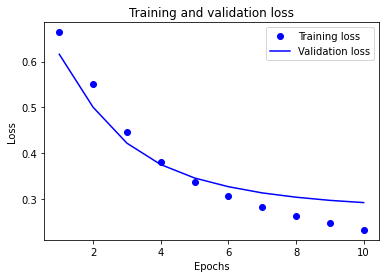

In [30]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

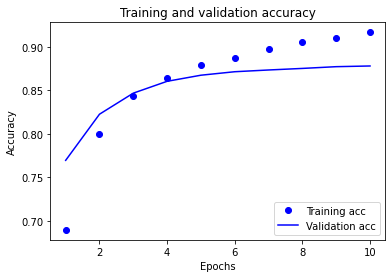

In [31]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping?version=nightly).

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [32]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

  1/782 [..............................] - ETA: 0s - loss: 0.1439 - accuracy: 0.9688

 13/782 [..............................] - ETA: 3s - loss: 0.2881 - accuracy: 0.8822

 25/782 [..............................] - ETA: 3s - loss: 0.3011 - accuracy: 0.8775

 37/782 [>.............................] - ETA: 3s - loss: 0.3033 - accuracy: 0.8767

 50/782 [>.............................] - ETA: 3s - loss: 0.3256 - accuracy: 0.8694

 62/782 [=>............................] - ETA: 3s - loss: 0.3289 - accuracy: 0.8644

 74/782 [=>............................] - ETA: 2s - loss: 0.3194 - accuracy: 0.8699

 86/782 [==>...........................] - ETA: 2s - loss: 0.3206 - accuracy: 0.8681

 98/782 [==>...........................] - ETA: 2s - loss: 0.3139 - accuracy: 0.8728

110/782 [===>..........................] - ETA: 2s - loss: 0.3077 - accuracy: 0.8756

122/782 [===>..........................] - ETA: 2s - loss: 0.3023 - accuracy: 0.8783

134/782 [====>.........................] - ETA: 2s - loss: 0.3022 - accuracy: 0.8783

146/782 [====>.........................] - ETA: 2s - loss: 0.3070 - accuracy: 0.8765

158/782 [=====>........................] - ETA: 2s - loss: 0.3109 - accuracy: 0.8736

170/782 [=====>........................] - ETA: 2s - loss: 0.3113 - accuracy: 0.8743

182/782 [=====>........................] - ETA: 2s - loss: 0.3105 - accuracy: 0.8752

194/782 [======>.......................] - ETA: 2s - loss: 0.3097 - accuracy: 0.8750

206/782 [======>.......................] - ETA: 2s - loss: 0.3103 - accuracy: 0.8758

218/782 [=======>......................] - ETA: 2s - loss: 0.3145 - accuracy: 0.8741

230/782 [=======>......................] - ETA: 2s - loss: 0.3136 - accuracy: 0.8743

242/782 [========>.....................] - ETA: 2s - loss: 0.3129 - accuracy: 0.8747

254/782 [========>.....................] - ETA: 2s - loss: 0.3117 - accuracy: 0.8746

266/782 [=========>....................] - ETA: 2s - loss: 0.3104 - accuracy: 0.8750

278/782 [=========>....................] - ETA: 2s - loss: 0.3107 - accuracy: 0.8743

291/782 [==========>...................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8739

303/782 [==========>...................] - ETA: 2s - loss: 0.3102 - accuracy: 0.8739

315/782 [===========>..................] - ETA: 2s - loss: 0.3094 - accuracy: 0.8742

327/782 [===========>..................] - ETA: 1s - loss: 0.3096 - accuracy: 0.8737

339/782 [============>.................] - ETA: 1s - loss: 0.3099 - accuracy: 0.8736

351/782 [============>.................] - ETA: 1s - loss: 0.3094 - accuracy: 0.8732

363/782 [============>.................] - ETA: 1s - loss: 0.3086 - accuracy: 0.8733

375/782 [=============>................] - ETA: 1s - loss: 0.3095 - accuracy: 0.8727

388/782 [=============>................] - ETA: 1s - loss: 0.3093 - accuracy: 0.8730

401/782 [==============>...............] - ETA: 1s - loss: 0.3085 - accuracy: 0.8735

413/782 [==============>...............] - ETA: 1s - loss: 0.3087 - accuracy: 0.8736

425/782 [===============>..............] - ETA: 1s - loss: 0.3074 - accuracy: 0.8744

437/782 [===============>..............] - ETA: 1s - loss: 0.3082 - accuracy: 0.8741

449/782 [================>.............] - ETA: 1s - loss: 0.3095 - accuracy: 0.8732

461/782 [================>.............] - ETA: 1s - loss: 0.3097 - accuracy: 0.8732

473/782 [=================>............] - ETA: 1s - loss: 0.3103 - accuracy: 0.8727

485/782 [=================>............] - ETA: 1s - loss: 0.3108 - accuracy: 0.8723

497/782 [==================>...........] - ETA: 1s - loss: 0.3101 - accuracy: 0.8724

509/782 [==================>...........] - ETA: 1s - loss: 0.3112 - accuracy: 0.8721

521/782 [==================>...........] - ETA: 1s - loss: 0.3106 - accuracy: 0.8727

533/782 [===================>..........] - ETA: 1s - loss: 0.3105 - accuracy: 0.8731

546/782 [===================>..........] - ETA: 1s - loss: 0.3105 - accuracy: 0.8733

558/782 [====================>.........] - ETA: 0s - loss: 0.3104 - accuracy: 0.8734

570/782 [====================>.........] - ETA: 0s - loss: 0.3107 - accuracy: 0.8733

582/782 [=====================>........] - ETA: 0s - loss: 0.3100 - accuracy: 0.8739

594/782 [=====================>........] - ETA: 0s - loss: 0.3102 - accuracy: 0.8738

606/782 [======================>.......] - ETA: 0s - loss: 0.3120 - accuracy: 0.8732

618/782 [======================>.......] - ETA: 0s - loss: 0.3111 - accuracy: 0.8736

630/782 [=======================>......] - ETA: 0s - loss: 0.3105 - accuracy: 0.8738

643/782 [=======================>......] - ETA: 0s - loss: 0.3106 - accuracy: 0.8742

655/782 [========================>.....] - ETA: 0s - loss: 0.3110 - accuracy: 0.8740

667/782 [========================>.....] - ETA: 0s - loss: 0.3108 - accuracy: 0.8736

679/782 [=========================>....] - ETA: 0s - loss: 0.3113 - accuracy: 0.8732

691/782 [=========================>....] - ETA: 0s - loss: 0.3121 - accuracy: 0.8729

703/782 [=========================>....] - ETA: 0s - loss: 0.3119 - accuracy: 0.8729

715/782 [==========================>...] - ETA: 0s - loss: 0.3115 - accuracy: 0.8730

727/782 [==========================>...] - ETA: 0s - loss: 0.3107 - accuracy: 0.8734

739/782 [===========================>..] - ETA: 0s - loss: 0.3101 - accuracy: 0.8734

751/782 [===========================>..] - ETA: 0s - loss: 0.3098 - accuracy: 0.8737

764/782 [============================>.] - ETA: 0s - loss: 0.3102 - accuracy: 0.8737

777/782 [============================>.] - ETA: 0s - loss: 0.3105 - accuracy: 0.8736

782/782 [==============================] - 3s 4ms/step - loss: 0.3104 - accuracy: 0.8735


0.8734800219535828


Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Exercise: multiclass classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multiclass classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

We have prepared a [dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) for you to use containing the body of several thousand programming questions (for example, "How can sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python. 

The dataset you will work with contains 8,000 questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: to increase the difficulty of the classification problem, we have replaced any occurences of the words Python, CSharp, JavaScript, or Java in the programming questions with the word *blank* (as many questions contain the language they're about). 

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) we have prepreared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications. 

1. Modify the last layer of your model to read `Dense(4)`, as there are now four output classes.

1. When you compile your model, change the loss to [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy?version=nightly). This is the correct loss function to use for a multiclass classification problem, when the labels for each class are integers (in our case, they can be 0, *1*, *2*, or *3*).

1. Once these changes are complete, you will be able to train a multiclass classifier. 

If you get stuck, you can find a solution [here](https://github.com/tensorflow/examples/blob/master/community/text_classification_solution.ipynb).


## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, we recommend reading [this guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.
